In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import scipy.io
from scipy.interpolate import interp1d
from statsmodels.distributions.empirical_distribution import ECDF

In [2]:
dataPath = r'/Users/hyx020222/Documents/GitHub/Passive-Handwriting-Tracking/data'
shapeType = 'eight'
shapePath = fr'{dataPath}/{shapeType}'
movPath = fr'{shapePath}/{shapeType}.mov'
matPath = fr'{shapePath}/{shapeType}.mat'

In [3]:
def extract_added_black_points(path):
    cap = cv2.VideoCapture(path)

    # 读取第一帧
    ret, prev_frame = cap.read()
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

    added_black_points_sequence = []

    while True:
        # 读取下一帧
        ret, frame = cap.read()
        if not ret:
            break

        # 转换为灰度图
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # 计算相邻帧的差异
        diff = cv2.absdiff(prev_gray, gray)

        # 通过阈值化得到黑点
        _, thresh = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

        # 查找轮廓
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # 提取新增黑点的坐标
        added_points = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > 5:  # 考虑面积大于5的轮廓为新增黑点
                M = cv2.moments(contour)
                cx = int(M['m10'] / M['m00'])
                cy = int(M['m01'] / M['m00'])
                added_points.append((cx, cy))

        added_black_points_sequence.append(added_points)

        # 更新上一帧
        prev_gray = gray

    cap.release()
    return added_black_points_sequence

In [4]:
sequence = extract_added_black_points(movPath)

# 删除空时刻
sequence = [points for points in sequence if points]
print(sequence)

[[(285, 130)], [(275, 130)], [(264, 132)], [(252, 135)], [(244, 137)], [(234, 139)], [(225, 142)], [(216, 144)], [(205, 148)], [(199, 151)], [(186, 156)], [(175, 160)], [(166, 165)], [(158, 169)], [(146, 175)], [(143, 178)], [(133, 187)], [(120, 197)], [(112, 205)], [(106, 212)], [(100, 219)], [(90, 233)], [(84, 241)], [(79, 249)], [(75, 257)], [(69, 269)], [(63, 280)], [(60, 288)], [(56, 300)], [(53, 310)], [(52, 319)], [(51, 329)], [(50, 343)], [(50, 353)], [(52, 361)], [(56, 374)], [(59, 382)], [(65, 393)], [(72, 404)], [(79, 415)], [(85, 422)], [(96, 434)], [(103, 442)], [(113, 452)], [(123, 461)], [(140, 474)], [(148, 479)], [(165, 488)], [(186, 497)], [(201, 504)], [(219, 511)], [(238, 519)], [(252, 524)], [(275, 532)], [(295, 539)], [(312, 545)], [(333, 553)], [(352, 560)], [(365, 565)], [(393, 575)], [(414, 583)], [(425, 587)], [(447, 596)], [(468, 607)], [(484, 617)], [(503, 632)], [(523, 648)], [(531, 656)], [(550, 674), (536, 660)], [(559, 685)], [(568, 698)], [(582, 722)], 

In [5]:
### Transform tuple into list ###
pointList = []

cnt = 0
for points in tqdm(sequence):
    xThis, yThis = zip(*points)
    xThis = int(xThis[0])
    yThis = int(yThis[0])

    # Check if this point is abnormally far from last point
    if cnt > 0:
        xLast = pointList[-1][0]
        yLast = pointList[-1][1]
        if math.sqrt((xThis - xLast)**2 + (yThis - yLast)**2) > 50:
            continue

    pointList.append([xThis, yThis])

    cnt += 1

# 提取 x 和 y 坐标
xPoint, yPoint = zip(*pointList)

100%|██████████| 176/176 [00:00<00:00, 679739.87it/s]

[[285, 130], [275, 130], [264, 132], [252, 135], [244, 137], [234, 139], [225, 142], [216, 144], [205, 148], [199, 151], [186, 156], [175, 160], [166, 165], [158, 169], [146, 175], [143, 178], [133, 187], [120, 197], [112, 205], [106, 212], [100, 219], [90, 233], [84, 241], [79, 249], [75, 257], [69, 269], [63, 280], [60, 288], [56, 300], [53, 310], [52, 319], [51, 329], [50, 343], [50, 353], [52, 361], [56, 374], [59, 382], [65, 393], [72, 404], [79, 415], [85, 422], [96, 434], [103, 442], [113, 452], [123, 461], [140, 474], [148, 479], [165, 488], [186, 497], [201, 504], [219, 511], [238, 519], [252, 524], [275, 532], [295, 539], [312, 545], [333, 553], [352, 560], [365, 565], [393, 575], [414, 583], [425, 587], [447, 596], [468, 607], [484, 617], [503, 632], [523, 648], [531, 656], [550, 674], [559, 685], [568, 698], [582, 722], [586, 733], [594, 753], [596, 763], [601, 785], [602, 798], [603, 808], [603, 834], [601, 844], [595, 872], [590, 885], [581, 907], [573, 924], [563, 944], 

In [6]:
### Rotate for pi ###
# 将点列表转换为NumPy数组以便于计算
points_array = np.array(pointList)

# 计算重心
centroid = np.mean(points_array, axis=0)
# 将每个点相对于重心进行旋转180度
rotated_points = 2 * centroid - points_array

# 绘制旋转后的时序曲线
x_rotated, y_rotated = rotated_points.T
# 合并x和y坐标成一个完整的点列表
rotatedList = list(zip(x_rotated.tolist(), y_rotated.tolist()))

[(323.51724137931035, 921.6896551724137), (333.51724137931035, 921.6896551724137), (344.51724137931035, 919.6896551724137), (356.51724137931035, 916.6896551724137), (364.51724137931035, 914.6896551724137), (374.51724137931035, 912.6896551724137), (383.51724137931035, 909.6896551724137), (392.51724137931035, 907.6896551724137), (403.51724137931035, 903.6896551724137), (409.51724137931035, 900.6896551724137), (422.51724137931035, 895.6896551724137), (433.51724137931035, 891.6896551724137), (442.51724137931035, 886.6896551724137), (450.51724137931035, 882.6896551724137), (462.51724137931035, 876.6896551724137), (465.51724137931035, 873.6896551724137), (475.51724137931035, 864.6896551724137), (488.51724137931035, 854.6896551724137), (496.51724137931035, 846.6896551724137), (502.51724137931035, 839.6896551724137), (508.51724137931035, 832.6896551724137), (518.5172413793103, 818.6896551724137), (524.5172413793103, 810.6896551724137), (529.5172413793103, 802.6896551724137), (533.5172413793103

In [7]:
# 读取.mat文件
matData = scipy.io.loadmat(matPath)

# 获取.mat文件中的变量
matData = matData['rotated']
# 转换成pointList的格式
matData = matData.T.tolist()

# 提取 x 和 y 坐标
xMat, yMat = zip(*matData)


[[2.440922017310777, -1.4230080739831306], [2.440922017310777, -1.4230080739831306], [2.4413202831840097, -1.423241546610896], [2.4417466893078608, -1.4234750489013845], [2.4422024490418464, -1.4237077097816797], [2.4425138868387646, -1.4238158800523355], [2.4427600951632606, -1.4238549920862311], [2.4429815184525348, -1.4238530953084754], [2.443202101034117, -1.4238265104011272], [2.44343760082991, -1.4237857110900887], [2.4436992759263254, -1.4237379383435398], [2.443995715971945, -1.4236885047461671], [2.444333829307966, -1.4236415027124074], [2.444712676696494, -1.423600522422914], [2.4451317431684365, -1.42356853244988], [2.4455908133070907, -1.423548052944474], [2.4460898860201237, -1.423541268987598], [2.4466291144088643, -1.4235501069486507], [2.4472087622592675, -1.423576287288066], [2.4478291719519114, -1.423621361995367], [2.448469852397681, -1.4236840180956682], [2.449112742913056, -1.4237631047200452], [2.449741820073919, -1.4238576012341218], [2.450405739765204, -1.423963

In [8]:
### Scale ground truth to the same size as estimated ###
min_x_rotated, max_x_rotated = min(x_rotated), max(x_rotated)
min_y_rotated, max_y_rotated = min(y_rotated), max(y_rotated)

min_xMat, max_xMat = min(xMat), max(xMat)
min_yMat, max_yMat = min(yMat), max(yMat)

# 缩放 x_rotated 和 y_rotated 到 xMat 和 yMat 的大小范围
xScaled = [min_xMat + (x - min_x_rotated) / (max_x_rotated - min_x_rotated) * (max_xMat - min_xMat) for x in x_rotated]
yScaled = [min_yMat + (y - min_y_rotated) / (max_y_rotated - min_y_rotated) * (max_yMat - min_yMat) for y in y_rotated]

In [23]:
# 将 xScaled 和 yScaled 线性插值到与 xMat 和 yMat 长度相等
interp_func_x = interp1d(np.linspace(0, 1, len(xScaled)), xScaled, kind='linear')
interp_func_y = interp1d(np.linspace(0, 1, len(yScaled)), yScaled, kind='linear')

# 生成新的 x 和 y
xInterp = interp_func_x(np.linspace(0, 1, len(xMat)))
yInterp = interp_func_y(np.linspace(0, 1, len(yMat)))

# 合并x和y坐标成一个完整的点列表
interpList = list(zip(xInterp.tolist(), yInterp.tolist()))

print(len(xInterp), len(yInterp), len(xMat), len(yMat))

368 368 368 368


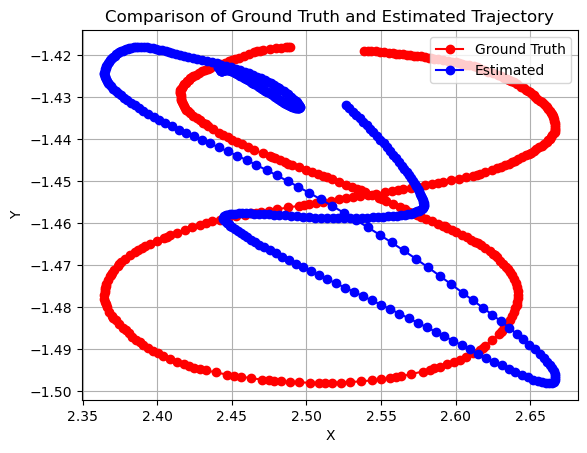

In [27]:
### Plot figure to compare ###
fig, ax = plt.subplots()

plt.plot(xInterp, yInterp, 
         marker='o', 
         linestyle='-', 
         color='r',
         label='Ground Truth')

plt.plot(xMat, yMat, 
         marker='o', 
         linestyle='-', 
         color='b',
         label='Estimated')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Comparison of Ground Truth and Estimated Trajectory')
ax.grid(True)
# ax.axes.set_aspect('equal')
ax.legend(loc='upper right')

plt.show()

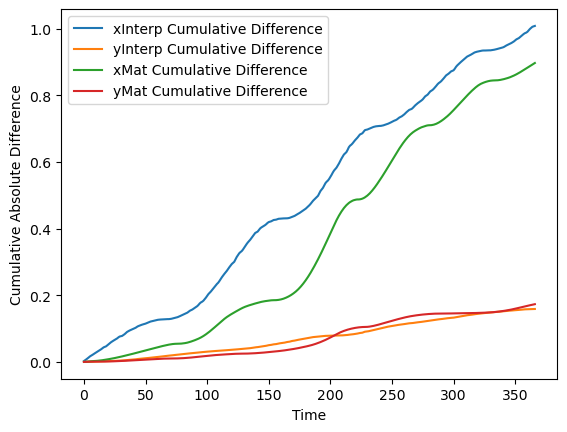

In [18]:
# 计算 xInterp 和 yInterp 的差异
diff_x_interp = np.abs(np.diff(xInterp))
diff_y_interp = np.abs(np.diff(yInterp))

# 计算 xMat 和 yMat 的差异
diff_x_mat = np.abs(np.diff(xMat))
diff_y_mat = np.abs(np.diff(yMat))

# 计算 xInterp 和 yInterp 的累积差异
cumulative_diff_x_interp = np.cumsum(diff_x_interp)
cumulative_diff_y_interp = np.cumsum(diff_y_interp)

# 计算 xMat 和 yMat 的累积差异
cumulative_diff_x_mat = np.cumsum(diff_x_mat)
cumulative_diff_y_mat = np.cumsum(diff_y_mat)

# 绘制累积差异图
plt.plot(cumulative_diff_x_interp, label='xInterp')
plt.plot(cumulative_diff_y_interp, label='yInterp')
plt.plot(cumulative_diff_x_mat, label='xMat')
plt.plot(cumulative_diff_y_mat, label='yMat')

plt.xlabel('Time')
plt.ylabel('Cumulative Absolute Difference')
plt.legend()
plt.show()
